In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Angry\ Hawks

!pwd

Mounted at /content/drive
/content/drive/My Drive/Angry Hawks
/content/drive/My Drive/Angry Hawks


In [ ]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from joblib import Parallel, delayed
import tqdm
import jieba
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score
from sklearn.metrics import mean_squared_error

import nltk
from nltk.corpus import stopwords
import re


# Load Data

In [ ]:
trainset = pd.read_csv("sample_2000.csv")

trainset

,ID,Text,Anger,Hawk,Dove,Protest,Information,Power,News,Irrelevant
0,1,【石原慎太郎:中国反对东京购买钓鱼岛等同宣战】日本东京都知事石原慎太郎当地时间17日在华盛顿...,0,0,0,0,0,0,1,0
1,2,最近中菲在黄岩岛海域冲突不断升级，军事对峙进入第14天，中国的罗援少将表示：“我们的执法船队...,1,1,0,0,0,0,0,0
2,3,[霹雳]铁道部12306，大学教务处选课系统，钓鱼岛，并称为三大难登入之地。（转）,0,0,0,0,0,0,0,1
3,4,【凤凰FM晚间推荐】资讯速递：朝鲜或随时进行第三次核试验。日本启用预警机加强警戒钓鱼岛。时事...,0,0,0,0,0,0,1,0
4,5,@汪渝@海南梁山@海南大学黄海宁@媚刺儿@海南大学-618剧组@余庆制造@才思敏爷@光影牧马...,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,1997,"[交通路况早知道]虎门大桥往京珠高速方向，威远站至南沙B站路段发生货车与客车相撞的交通事故,...",0,0,0,0,0,0,1,1
1996,1998,【微博惊现抵制日本人的餐厅】@海棠餐厅：亦庄这有不少日资企业。虽然我们只是一家餐厅，但也有明...,0,0,0,0,0,0,0,0
1997,1999,//@ukn： //@ukn： 大照明为我们的民族品牌保驾护航。最近看了@ukn： 的微博...,0,0,0,0,0,0,0,0
1998,2000,在中国，一夜暴富且能披上合法外衣的无外乎打黑和黑打，只不过是把掘取人民的财富从—个利益集团手...,1,0,0,0,0,0,0,0


In [ ]:
relevant = pd.read_csv("relevant_encoded.csv")
relevant

,mid,retweeted_status_mid,uid,retweeted_uid,source,image,text,geo,created_at,deleted_last_seen,permission_denied
0,m4wDf99LUI,NaN,uTZ5HS3KU,NaN,皮皮时光机,1.0,"今中南海(原名太液池)东岸万善门旁，有一水埠，水中有亭叫""水云榭""，站在水云榭四望，北面是北...",NaN,1/1/2012 18:23,NaN,NaN
1,mGvP0lgcAO,NaN,uRSRDSLKR,NaN,皮皮时光机,1.0,【广东省（粤）】粤A 广州，粤B 深圳，粤C 珠海，粤D 汕头，粤E 佛山，粤F 韶关，粤G...,NaN,1/2/2012 8:40,NaN,NaN
2,mhRqbz3o6h,mT51BgbebS,uRLOW2LS0,NaN,2012版Android客户端,0.0,还有这事？？//@uEMBUDE4O： 难怪在钓鱼岛等问题上那么软弱，原来是关公放曹操啊//...,NaN,1/3/2012 4:37,NaN,NaN
3,m9hqkMrUQ5,NaN,uCBTG01D4,NaN,Gtalk聊天机器人,0.0,2日南海海况报告：预计今天上午至明天上午，南海大部海域有中到大浪，大浪区主要在巴士海峡、东沙...,NaN,1/2/2012 4:31,NaN,NaN
4,m7dAaFT1DH,mdZXcH5utD,uVT4LMNJ0,NaN,新浪微博,0.0,老胡，先管管你们中南海里的族人西化的问题吧。己所不欲你懂的～//@uRLOKEMI3： 求...,NaN,1/2/2012 12:09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
376713,m9RMU5KYUz,NaN,uVT4D15M2,NaN,UC浏览器Android版,1.0,"2012注定是不平凡的一年。这一年，我们调戏了杜甫,模仿了甄嬛，认识了鸟叔,拯救了世界，学会...",NaN,12/29/2012 6:02,NaN,NaN
376714,mzHjASTBK7,NaN,uRU5IKSF,NaN,专业版微博,1.0,【广州南沙官员家庭财产申报公示春节后启动】备受关注的南沙区领导干部家庭财产公开申报工作将在春...,NaN,12/29/2012 8:21,NaN,NaN
376715,mT5fFPtZcL,NaN,uRLOEJGN4,NaN,分享按钮,1.0,解放军大校戴旭称中国应派苏-30巡飞钓岛， 对抗日本，展示对等还击的意志。http://t....,NaN,12/26/2012 6:26,NaN,NaN
376716,mu9cdjGmRr,NaN,u0YUFWEQ3,NaN,新浪微博,1.0,《你眼中的2013年是怎么样的？》从中日钓鱼岛之争、中菲黄岩岛之争，中韩、中俄渔业纠纷来看，...,NaN,12/29/2012 8:40,NaN,NaN


In [ ]:
stop_words_cn = [
    '的', '了', '和', '是', '就', '都', '而', '及', '與', 
    '著', '或', '一g', '沒有', '我們', '你們', '妳們', 
    '他們', '她們', '是否','cn','http',"。", "/","t"]
  

#Segmentation example for the first text
def jieba_cut(x, sep=' '):
  x=re.sub(r'u\S+', '', x)# remove usernames
  x=re.sub(r'z\S+', '', x)# remove links
  filtered_sentence = [w for w in jieba.cut(x, cut_all=False) if not w in stop_words_cn]
  return sep.join(filtered_sentence)

print('raw', trainset['Text'][0])
print('segmented', jieba_cut(trainset['Text'][0], ', '))

raw 【石原慎太郎:中国反对东京购买钓鱼岛等同宣战】日本东京都知事石原慎太郎当地时间17日在华盛顿接受了媒体的采访。他在谈及“购买”钓鱼岛后中方的反应时宣称，中方欲打破日本对钓鱼岛的“实际控制”，“这听起来和宣战布告差不多”。（环球网）http://t.cn/zOOL1Ld
segmented 【, 石原慎太郎, :, 中国, 反对, 东京, 购买, 钓鱼岛, 等同, 宣战, 】, 日本, 东京都, 知事, 石原慎太郎, 当地, 时间, 17, 日, 在, 华盛顿, 接受, 媒体, 采访, 他, 在, 谈及, “, 购买, ”, 钓鱼岛, 后, 中方, 反应, 时, 宣称, ，, 中方, 欲, 打破, 日本, 对, 钓鱼岛, “, 实际, 控制, ”, ，, “, 这, 听, 起来, 宣战, 布告, 差不多, ”, （, 环球网, ）, :, .


In [ ]:
%%time
trainset['seg_Text'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.tqdm_notebook(trainset['Text'].values)
)
trainset['seg_Text']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 554 ms, sys: 94.5 ms, total: 648 ms
Wall time: 6.3 s


In [ ]:
typelist= list()
for i in range(len(relevant['text'])):
  typelist.append(type(relevant['text'].values[i]))

[i for i in range(len(typelist)) if typelist[i] != str]

relevant['text'][62404] = str('NA')
relevant['text'][273722] = str('NA')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def count_vect_feature(feature, df, max_features=5000):
    start_time = time.time()
    cv = CountVectorizer(max_features=max_features,
                         ngram_range=(1,1))
    X_feature = cv.fit_transform(df[feature])
    print('Count Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    return X_feature, cv

In [ ]:
# this is the training set
X_text, cv = count_vect_feature('seg_Text', trainset, 20000)
train_feature = cv.get_feature_names()
X_text.shape

Count Vectorizer `seg_Text` completed in 0.11 sec.


(2000, 15183)

In [ ]:
%%time
relevant['seg_Text'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.tqdm_notebook(relevant['text'].values)
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 28.5 s, sys: 1.01 s, total: 29.5 s
Wall time: 3min 5s


In [ ]:
# this is the new data
X_text_relevant, cv_relevant = count_vect_feature('seg_Text', relevant, 400000)
full_feature = cv_relevant.get_feature_names()
X_text_relevant.shape



Count Vectorizer `seg_Text` completed in 11.92 sec.


(376718, 240534)

# Shape Control to make new text have the same DTM as the training text

In [ ]:
matching_features_ind = [full_feature.index(i) for i in train_feature]

In [ ]:
matched_feature_dtm = X_text_relevant.tocsr()[:,matching_features_ind]

# Support Vector Machine

In [ ]:
target =  'Anger'
X = X_text
y = trainset[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 2020)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((1600, 15183), (400, 15183), (1600,), (400,))

In [ ]:
import matplotlib.font_manager as fm
font_path = './SourceHanSansCN-Regular.otf'
prop = fm.FontProperties(fname=font_path)

def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

## Gridsearch Tuning of SVM

In [ ]:
%%time
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000,10000], 
              'class_weight': ['balanced'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,0.00001], 
              'kernel': ['linear'],
              'random_state':[1,2]}  
  
clf_svc = GridSearchCV(SVC(), param_grid, refit = True,cv=5) 
clf_svc.fit(train_X,train_y)

print(clf_svc.best_estimator_) 


SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
CPU times: user 2min 2s, sys: 14.3 ms, total: 2min 2s
Wall time: 2min 2s


In [ ]:
clf_svc_anger = SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
clf_svc_anger.fit(train_X, train_y)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

Valid:
Feature: Anger 	| Prediction accuracy: 0.8475
Feature: Anger 	| Prediction F1-score: 0.845732418114951
Feature: Anger 	| Prediction recall: 0.8475


<Figure size 432x432 with 0 Axes>

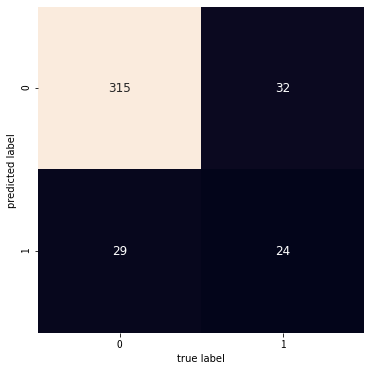

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       344
           1       0.45      0.43      0.44        56

    accuracy                           0.85       400
   macro avg       0.68      0.67      0.68       400
weighted avg       0.84      0.85      0.85       400



In [ ]:
predicted_valid = clf_svc_anger.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [ ]:
anger_class = clf_svc_anger.predict(matched_feature_dtm)

# Support for the use of force

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
Valid:
Feature: ['Hawk'] 	| Prediction accuracy: 0.870575
Feature: ['Hawk'] 	| Prediction F1-score: 0.8852605247101891
Feature: ['Hawk'] 	| Prediction recall: 0.9025


<Figure size 432x432 with 0 Axes>

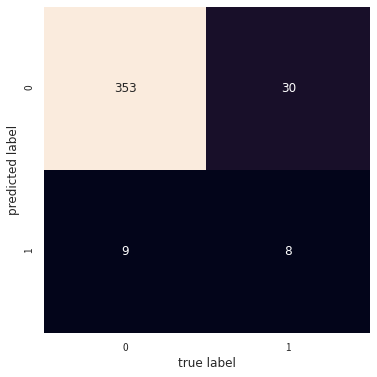

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       362
           1       0.47      0.21      0.29        38

    accuracy                           0.90       400
   macro avg       0.70      0.59      0.62       400
weighted avg       0.88      0.90      0.89       400



In [ ]:
target = ['Hawk']
X = X_text

y = trainset[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 2020)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

param_grid = {'C': [0.1, 1, 10, 100, 1000,10000], 
              'class_weight': ['balanced'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,0.00001], 
              'kernel': ['linear'],
              'random_state':[1,2]}

clf_svc_hawk = GridSearchCV(SVC(), param_grid, refit = True,cv=5)
clf_svc_hawk.fit(X = train_X,y=train_y)

print(clf_svc_hawk.best_estimator_) 

predicted_valid = clf_svc_hawk.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [ ]:
hawk_class = clf_svc_hawk.predict(matched_feature_dtm)

# Protest

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
Valid:
Feature: ['Protest'] 	| Prediction accuracy: 0.89825
Feature: ['Protest'] 	| Prediction F1-score: 0.9147855672636785
Feature: ['Protest'] 	| Prediction recall: 0.9175


<Figure size 432x432 with 0 Axes>

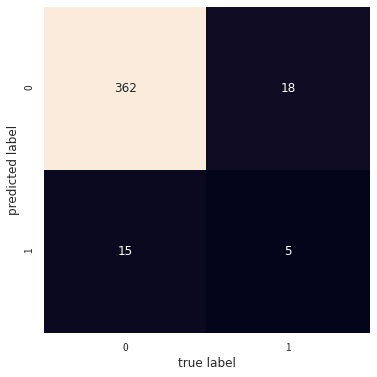

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       377
           1       0.25      0.22      0.23        23

    accuracy                           0.92       400
   macro avg       0.60      0.59      0.59       400
weighted avg       0.91      0.92      0.91       400



In [ ]:
target = ['Protest']
X = X_text

y = trainset[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 2020)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

param_grid = {'C': [0.1, 1, 10, 100, 1000,10000], 
              'class_weight': ['balanced'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,0.00001], 
              'kernel': ['linear'],
              'random_state':[1,2]}

clf_svc_Protest = GridSearchCV(SVC(), param_grid, refit = True,cv=5)
clf_svc_Protest.fit(X = train_X,y=train_y)

print(clf_svc_Protest.best_estimator_) 

predicted_valid = clf_svc_Protest.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [ ]:
protest_class = clf_svc_Protest.predict(matched_feature_dtm)

# Information

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
Valid:
Feature: ['Information'] 	| Prediction accuracy: 0.93475
Feature: ['Information'] 	| Prediction F1-score: 0.9499532844616932
Feature: ['Information'] 	| Prediction recall: 0.9525


<Figure size 432x432 with 0 Axes>

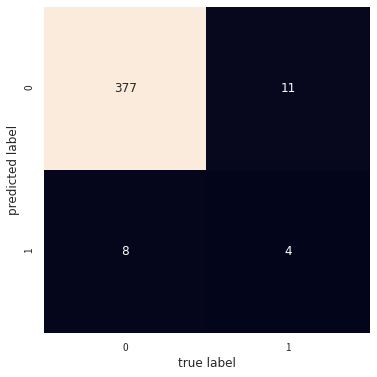

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       385
           1       0.33      0.27      0.30        15

    accuracy                           0.95       400
   macro avg       0.65      0.62      0.64       400
weighted avg       0.95      0.95      0.95       400



In [ ]:
target = ['Information']
X = X_text

y = trainset[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 2020)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

param_grid = {'C': [0.1, 1, 10, 100, 1000,10000], 
              'class_weight': ['balanced'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,0.00001], 
              'kernel': ['linear'],
              'random_state':[1,2]}

clf_svc_Information = GridSearchCV(SVC(), param_grid, refit = True,cv=5)
clf_svc_Information.fit(X = train_X,y=train_y)

print(clf_svc_Information.best_estimator_) 

predicted_valid = clf_svc_Information.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [ ]:
info_class = clf_svc_Information.predict(matched_feature_dtm)

# News

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
Valid:
Feature: ['News'] 	| Prediction accuracy: 0.5819375
Feature: ['News'] 	| Prediction F1-score: 0.8142336819329246
Feature: ['News'] 	| Prediction recall: 0.82


<Figure size 432x432 with 0 Axes>

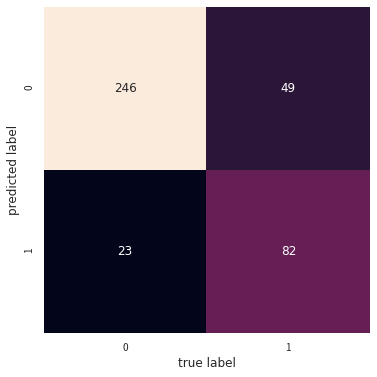

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       269
           1       0.78      0.63      0.69       131

    accuracy                           0.82       400
   macro avg       0.81      0.77      0.78       400
weighted avg       0.82      0.82      0.81       400



In [ ]:
target = ['News']
X = X_text

y = trainset[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 2020)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

param_grid = {'C': [0.1, 1, 10, 100, 1000,10000], 
              'class_weight': ['balanced'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,0.00001], 
              'kernel': ['linear'],
              'random_state':[1,2]}

clf_svc_News = GridSearchCV(SVC(), param_grid, refit = True,cv=5)
clf_svc_News.fit(X = train_X,y=train_y)

print(clf_svc_News.best_estimator_) 

predicted_valid = clf_svc_News.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [ ]:
News_class = clf_svc_News.predict(matched_feature_dtm)

# Irrelevant

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
Valid:
Feature: ['Irrelevant'] 	| Prediction accuracy: 0.6075
Feature: ['Irrelevant'] 	| Prediction F1-score: 0.8366776179388218
Feature: ['Irrelevant'] 	| Prediction recall: 0.84


<Figure size 432x432 with 0 Axes>

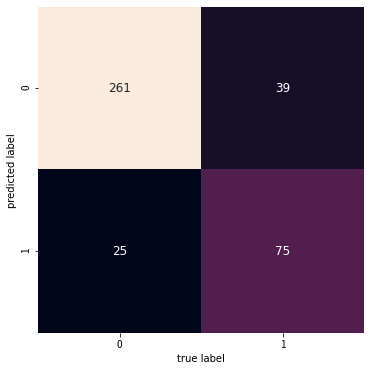

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       286
           1       0.75      0.66      0.70       114

    accuracy                           0.84       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.84      0.84      0.84       400



In [ ]:
target = ['Irrelevant']
X = X_text

y = trainset[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 2020)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

param_grid = {'C': [0.1, 1, 10, 100, 1000,10000], 
              'class_weight': ['balanced'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,0.00001], 
              'kernel': ['linear'],
              'random_state':[1,2]}

clf_svc_Irrelevant = GridSearchCV(SVC(), param_grid, refit = True,cv=5)
clf_svc_Irrelevant.fit(X = train_X,y=train_y)

print(clf_svc_Irrelevant.best_estimator_) 

predicted_valid = clf_svc_Irrelevant.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [ ]:
Irrelevant_class = clf_svc_Irrelevant.predict(matched_feature_dtm)

In [ ]:
import pandas as pd
pd.DataFrame({"Irrelevant_class": Irrelevant_class}).to_csv("irrelevant.csv")

In [ ]:
svm_results = pd.DataFrame({"anger_class": anger_class, "hawk_class": hawk_class, "protest_class": protest_class,
              "info_class": info_class, "News_class": News_class, "Irrelevant_class": Irrelevant_class})

# Sentiment Analysis

In [ ]:
pip install cnsenti

     |████████████████████████████████| 399kB 7.3MB/s 


In [ ]:
from cnsenti import Emotion

result = list()

for i in range(len(relevant)):
  emotion = Emotion()
  test_text = relevant['text'][i]
  result.append(emotion.emotion_count(test_text))

In [ ]:
sentiment = pd.DataFrame(result)
sentiment

,words,sentences,好,乐,哀,怒,惧,恶,惊
0,74,5,3,0,0,0,0,0,0
1,124,1,0,0,0,0,0,0,0
2,49,3,0,0,0,0,0,2,1
3,58,4,0,1,0,0,0,0,0
4,63,5,0,0,0,0,3,1,0
...,...,...,...,...,...,...,...,...,...
376713,84,6,4,1,1,0,0,3,0
376714,61,4,3,0,0,0,0,0,0
376715,89,7,2,0,1,2,0,1,0
376716,88,6,1,2,0,0,0,0,0


In [ ]:
sentiment = sentiment.rename(columns={"好": "positive", "乐": "happy", "哀": "sadness", "怒":"anger_sentiment",
                          "惧":"Fear","恶":"negative","惊":"surprise"})

In [ ]:
sentiment

,words,sentences,positive,happy,sadness,anger_sentiment,Fear,negative,surprise
0,74,5,3,0,0,0,0,0,0
1,124,1,0,0,0,0,0,0,0
2,49,3,0,0,0,0,0,2,1
3,58,4,0,1,0,0,0,0,0
4,63,5,0,0,0,0,3,1,0
...,...,...,...,...,...,...,...,...,...
376713,84,6,4,1,1,0,0,3,0
376714,61,4,3,0,0,0,0,0,0
376715,89,7,2,0,1,2,0,1,0
376716,88,6,1,2,0,0,0,0,0


In [ ]:
Classified_text = pd.concat([relevant, svm_results, sentiment], axis=1)
Classified_text["Anger_Ensemble_Sum"] = Classified_text["anger_class"]+ Classified_text["anger_sentiment"]
a = np.array(Classified_text['Anger_Ensemble_Sum'].values.tolist())
Classified_text['Anger_Ensemble'] = np.where(a > 1, 1, a).tolist()
Classified_text = Classified_text.fillna(9999) # NA replaced with 9999
Classified_text

#Classified_text.to_csv(r'Classified_text.csv', index = False, encoding="utf-8")

In [ ]:
(Classified_text["anger_class"] == Classified_text["anger_sentiment"]).sum()/len(Classified_text)

0.8524360396901661